In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from aux_files.empirical_study_tspl import find_optimal_parameters_tspl

c:\Users\leala\OneDrive\Desktop\MastersNotes\Topics_QF\VolatilityIsMostlyPathDependent-main\entrega\aux_files\empirical_study_tspl.py:161: SyntaxWarning: invalid escape sequence '\s'
  """


In [ ]:
#load data
dfs = []
for year in range(2003, 2024):
    dfs.append(pd.read_csv(f'data_fwd/option_fwd_price_{year}.csv',sep=';').drop(columns="Unnamed: 0"))

In [156]:
ivol_data = pd.concat(dfs, ignore_index=True)

In [ ]:
load_from = pd.to_datetime('2003-01-01') 
train_start_date = pd.to_datetime('2007-03-08')
test_start_date = pd.to_datetime('2022-03-23')
test_end_date = pd.to_datetime('2023-08-31')

In [ ]:
#load spx data
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)

In [7]:
ivol_data['date'] = pd.to_datetime(ivol_data['date'], format='%Y-%m-%d')
ivol_data['exdate'] = pd.to_datetime(ivol_data['exdate'], format='%Y-%m-%d')

In [62]:
len(ivol_data[ivol_data['date']>test_start_date])/len(ivol_data[ivol_data['date']>train_start_date])

0.14147151840795252

In [9]:
spx_data.index = pd.to_datetime(spx_data.index.date)

In [10]:
spx = spx_data['Close']

In [ ]:
#maturity in months and print proportion of data per mat

ivol_data['maturity'] = (
    (ivol_data['exdate'] - ivol_data['date']).dt.days/(30)
).round().astype(int)

a = len(ivol_data)
for i in range(1, 50):
    print(i, len(ivol_data[ivol_data['maturity']==i])/a)

1 0.2254921369858095
2 0.23500032142788885
3 0.14576344528998103
4 0.10687052595062056
5 0.0671525601007411
6 0.03905247498509173
7 0.02102471404018254
8 0.022496911686094877
9 0.019734803651961355
10 0.01972167626671063
11 0.019575778893133625
12 0.01963185985512386
13 0.010569137787545238
14 0.007907174328394283
15 0.006851336802180536
16 0.004824989753882762
17 0.0038528875710881695
18 0.004084016423903347
19 0.003633872592162449
20 0.0036085348081307165
21 0.0033367207135274425
22 0.0034380235872085987
23 0.003131170956972871
24 0.0026222434662783534
25 0.0006226820753855542
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0


In [15]:
frequencies = []
for i in range(1, 25):
    frequencies.append(len(ivol_data[ivol_data['maturity']==i]))

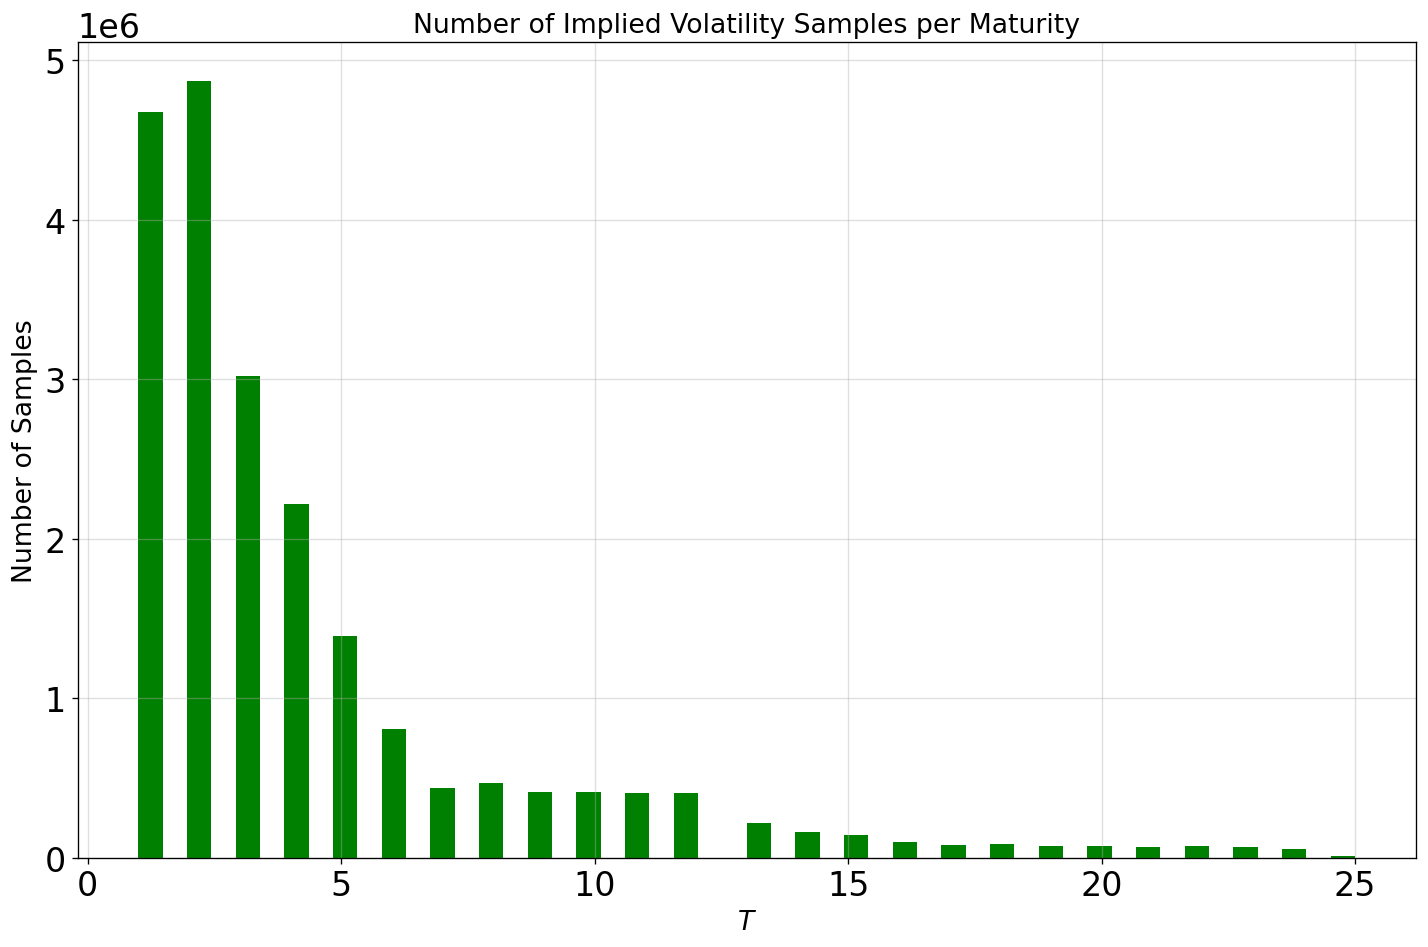

In [16]:
plt.hist(ivol_data['maturity'], bins=50, color='g')
plt.ylabel('Number of Samples',fontsize=16)
plt.xlabel(r'$T$', fontsize=16)
plt.title('Number of Implied Volatility Samples per Maturity', fontsize=16)
plt.tight_layout()
plt.savefig('number_of_samples.pdf', format='pdf')
plt.show()

In [ ]:
#merge the ivol and the spx price data
merged = ivol_data.merge(spx.rename('underlying_price'), 
                       left_on='date', 
                       
                       right_index=True)

In [13]:
merged.rename(columns={'strike': 'strike_price'}, inplace=True)
merged['strike_distance'] = abs(merged['strike_price'] - merged['forward_price']) #to see ATM
#merged['strike_distance'] = np.where((merged['strike_distance'].notnull()) & (merged['forward_price'] != np.inf), merged['strike_distance'],  abs(merged['strike_price'] - merged['underlying_price']))
merged.drop(columns='forward_price', inplace=True)
merged.dropna(inplace=True)

In [ ]:
#we find the atm maturity here and build the data set

atm_by_maturity = {}
for maturity, group in merged.groupby('maturity'):

    atm_options = group.loc[group.groupby('date')['strike_distance'].idxmin()]
    atm_by_maturity[maturity] = atm_options[['date', 'impl_volatility', 'underlying_price']].set_index('date')
    atm_by_maturity[maturity].columns = [f'ivol', 'spx']


for maturity in atm_by_maturity:
   
    df = atm_by_maturity[maturity]
    all_business_days = pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq='B'  # Business days only
    )
    
    df_reindexed = df.reindex(all_business_days)
    df_reindexed['ivol'] = df_reindexed['ivol'].ffill()
    df_reindexed.dropna(inplace=True)
    # Update in dictionary
    atm_by_maturity[maturity] = df_reindexed

print("Example maturity (3m) with forward-filled data:")
print(atm_by_maturity[3].head(10))

Example maturity (3m) with forward-filled data:
                ivol         spx
2003-01-02  0.257492  909.030029
2003-01-03  0.246045  908.590027
2003-03-20  0.258529  875.669983
2003-03-24  0.263303  864.229980
2003-03-25  0.247772  874.739990
2003-03-26  0.252968  869.950012
2003-03-27  0.251871  868.520020
2003-03-28  0.256327  863.500000
2003-04-01  0.249049  858.479980
2003-04-02  0.240826  880.900024


In [ ]:
train_r2=[]
test_r2=[]
for T in range(1,2):
    
    print(T)
    vol = pd.Series(
        data=atm_by_maturity[T]['ivol'].values,
        index=atm_by_maturity[T].index,
        name=None 
    )
    spx = pd.Series(
        data=atm_by_maturity[T]['spx'].values,
        index=atm_by_maturity[T].index,
        name=None 
    )
    
    p = 1
    setting = [(1, 1), (2, 1/2)] 
    max_delta=800
    if T>5:
        max_delta = 1000

    
    sol = find_optimal_parameters_tspl(vol=vol, index=spx, p=p, tspl=True, setting=setting, train_start_date=train_start_date,
                                test_start_date=test_start_date, test_end_date=test_end_date, 
                                max_delta=max_delta, lambda_reg=0)
    

    print(T, sol['train_r2'], sol['test_r2'])
    train_r2.append(sol['train_r2'])
    test_r2.append(sol['test_r2'])

1
1 0.9290428529732185 0.8305144633158708


In [ ]:
train_r2s, test_r2s = {}, {}
lambda_regs = [0, 0.01 ,0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
for lambda_reg in lambda_regs:
    train_r2s[lambda_reg]=[]
    test_r2s[lambda_reg]=[]
    for T in range(1,13):
        
        print(T)
        vol = pd.Series(
            data=atm_by_maturity[T]['ivol'].values,
            index=atm_by_maturity[T].index,
            name=None 
        )
        spx = pd.Series(
            data=atm_by_maturity[T]['spx'].values,
            index=atm_by_maturity[T].index,
            name=None 
        )
       
        
        p = 1
        setting = [(1, 1), (2, 1/2)] 
        max_delta=800
        if T>5:
            max_delta = 1000
        
        sol = find_optimal_parameters_tspl(index=spx, vol=vol, setting=setting, train_start_date=train_start_date, test_start_date=test_start_date,
                  test_end_date=test_end_date, max_delta=max_delta, fixed_initial=False, use_jacob=True,p=p,lambda_reg=lambda_reg)
        

        print(T, sol['train_r2'], sol['test_r2'])
        train_r2s[lambda_reg].append(sol['train_r2'])
        test_r2s[lambda_reg].append(sol['test_r2'])

1
1 0.9290428529424557 0.8305177539160696
2
2 0.9494085498481293 0.8794849861703677
3
3 0.9216932761555191 0.8675514349568976
4
4 0.9169182558538772 0.7812280745251923
5
5 0.9128077165087848 0.7252461290542473
6
6 0.9052217194364435 0.7370422035735561
7
7 0.8465844913745997 0.7440662513596468
8
8 0.8124575122192179 0.6795427260103506
9
9 0.8833043478335639 0.6549540819753805
10
10 0.8808317874988696 0.6258103340204483
11
11 0.854530350524342 0.5596510816194303
12
12 0.8495744797428608 0.5874100191674602
1
1 0.9290428529556225 0.8305172377608526
2
2 0.9494085499048085 0.8794866441775147
3
3 0.9213687135459944 0.8674740808207588
4
4 0.8776531455155058 0.7448393921605321
5
5 0.9128077202619982 0.7252448412217787
6
6 0.9052217344464902 0.7370514453054828
7
7 0.8465845044808449 0.7440662306641874
8
8 0.8124575270138763 0.6795426580409254
9
9 0.883304347833564 0.6549540819757396
10
10 0.8808317874988696 0.62581033402092
11
11 0.854530350524342 0.5596510816193494
12
12 0.8495744797428608 0.58

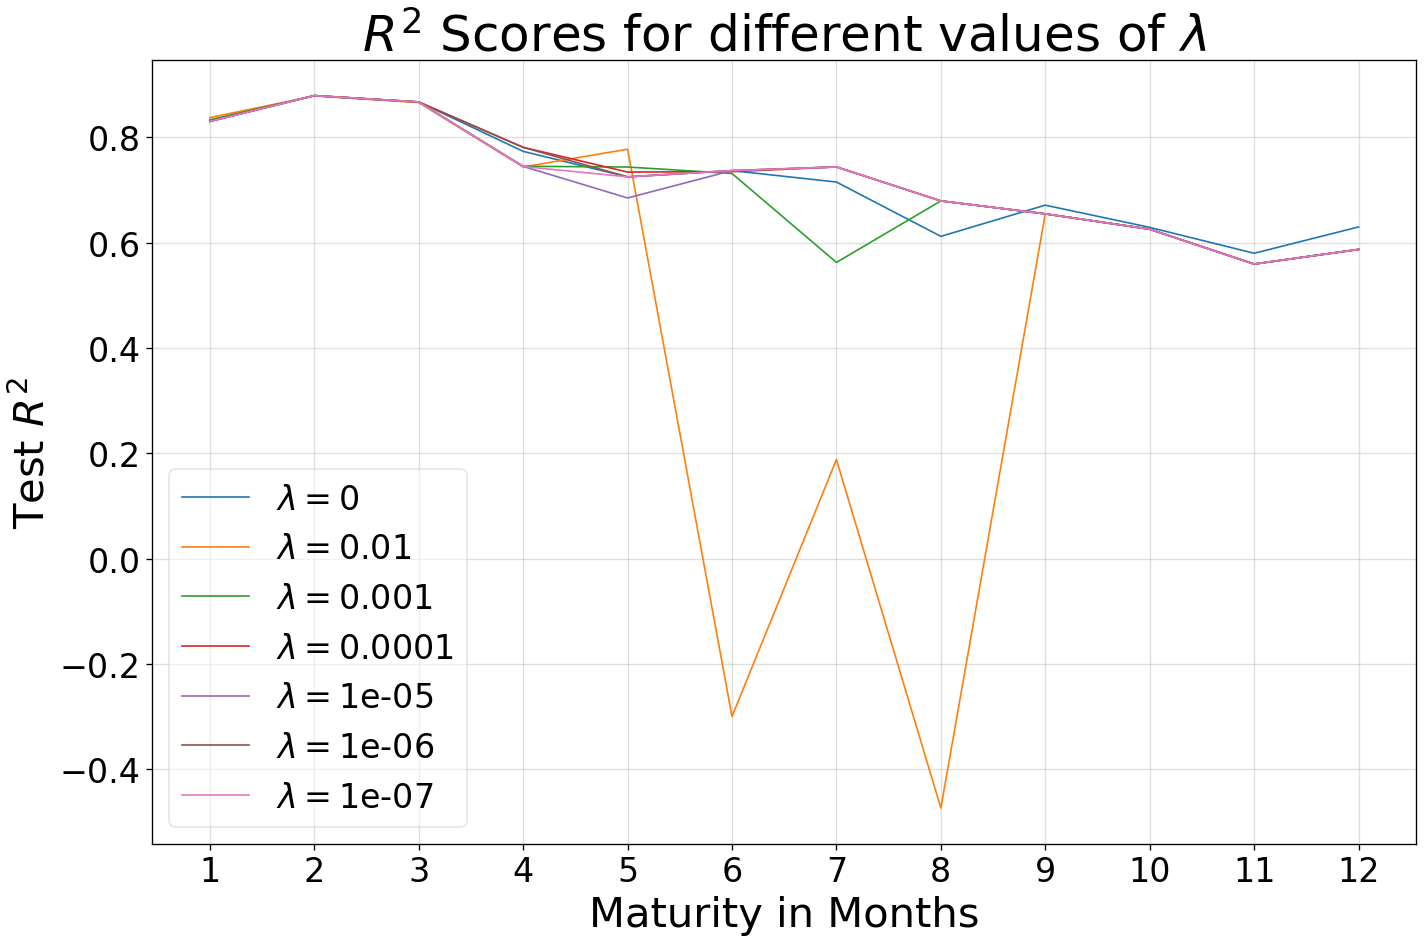

In [155]:
mean_trains, mean_tests=[],[]
for lambda_reg in [0, 0.01 ,0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    train_r2, test_r2 = train_r2s[lambda_reg], test_r2s[lambda_reg]
    mean_trains.append((lambda_reg, np.mean(train_r2)))
    mean_tests.append((lambda_reg, np.mean(test_r2)))
    #plt.plot(np.arange(1,13), train_r2)
    plt.plot(np.arange(1,13), test_r2, label=rf'$\lambda = ${lambda_reg}')

plt.xlabel(r"Maturity in Months")
plt.ylabel(r"Test $R^2$")
plt.xticks(np.arange(1,13))
plt.legend()
plt.title(r"$R^2$ Scores for different values of $\lambda$")
plt.tight_layout()
plt.savefig("reg_r2.pdf", format="pdf")


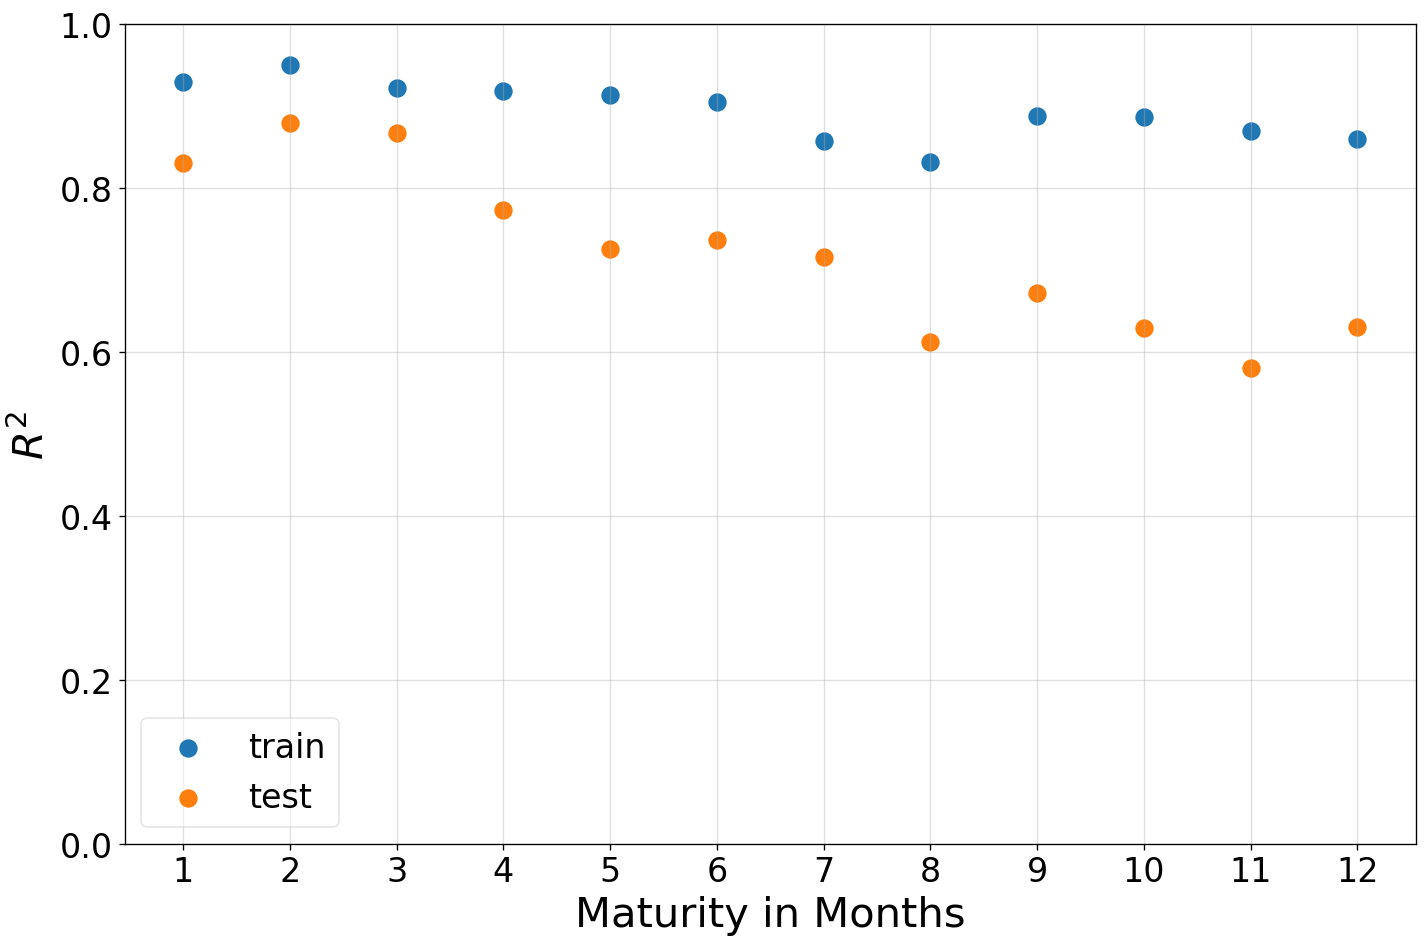

In [243]:
plt.scatter(np.arange(1,13), train_r2, label="train", marker="o", s=100)
plt.scatter(np.arange(1,13), test_r2, label="test", marker = "o", s=100)
plt.xlabel(r"Maturity in Months")
plt.ylabel(r"$R^2$")
plt.xticks(np.arange(1,13))
plt.legend()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('results_e2.pdf', format="pdf")
plt.show()

In [ ]:
def plot_timeseries(y, label, score=0, display_score=True, secondary=None, secondary_label=None, figsize=(12, 5),
                    color='r', color_secondary='k', hline=1, add_hline=True, ylim=None,
                    train_start_date=None, test_start_date=None, test_end_date=None):

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel(label, fontsize=14)

    # Split data
    if test_start_date is not None and test_end_date is not None:
        y_train = y.loc[:test_start_date]
        y_test = y.loc[test_start_date:test_end_date]
    else:
        y_train = y
        y_test = None

    # Plot background for test period
    ax.axvspan(train_start_date, test_start_date, color='yellow', alpha=0.3, label='Train Period')
    if test_start_date is not None and test_end_date is not None:
        ax.axvspan(test_start_date, test_end_date, color='lightgreen', alpha=0.3, label='Test Period')

    # Plot train and test separately
    y_train.plot(ax=ax, color='orange', label='1-month ATM implied volatility', linewidth=2)
    if y_test is not None:
        y_test.plot(ax=ax, color='orange', linewidth=2)

    # Optional horizontal line
    if add_hline:
        ax.axhline(hline, linestyle='--', color='grey', alpha=0.6)

    handles, labels_ = ax.get_legend_handles_labels()

    # Add score patch
    if display_score:
        patch = Patch(facecolor='white', edgecolor='white', label=f'Test $R^2 = {score:.3f}$')
        handles.append(patch)

    # Plot secondary axis if given
    if secondary is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel(secondary_label, color='b', fontsize=14)
        ax2.tick_params(axis='y', colors='b')
        secondary.plot(ax=ax2, color='b', alpha=0.6, linewidth=1.5, linestyle='--', label=secondary_label)
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles.extend(handles2)
        ax2.grid(False)

    ax.legend(handles=handles, loc='upper left', fontsize=12, framealpha=0.4)

    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel('')
    ax.grid(True, linestyle=':', alpha=0.5)
    fig.tight_layout()
    return fig

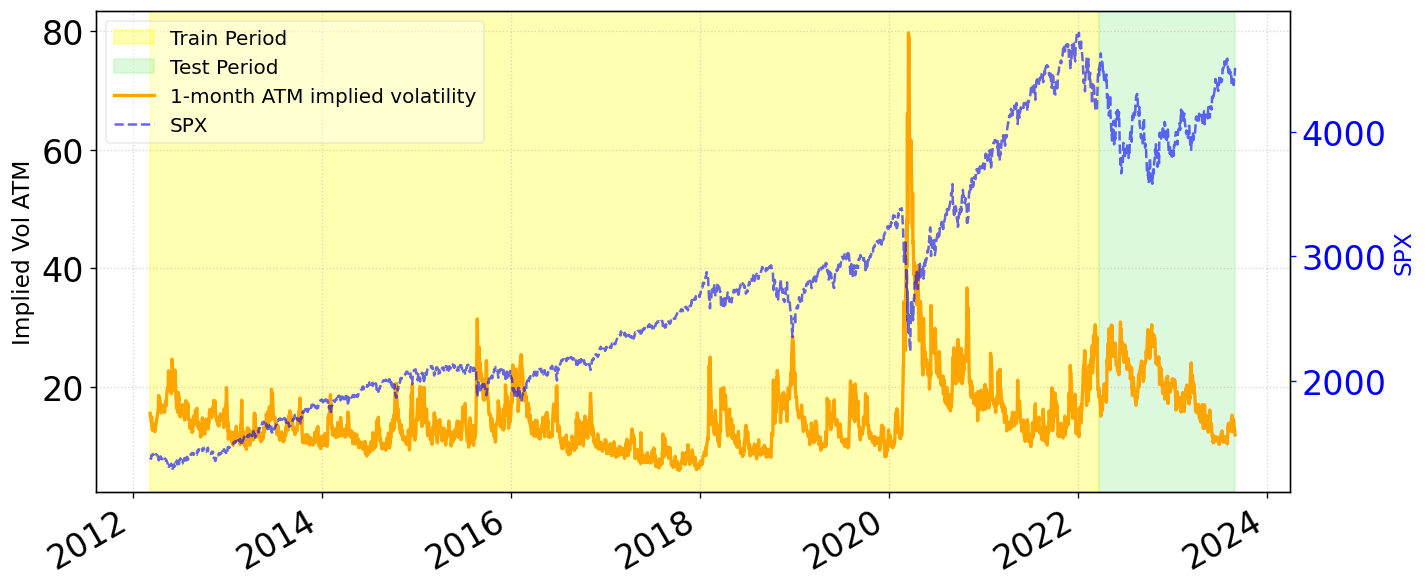

In [63]:
#load_from = pd.to_datetime('2003-01-01') 
train_start_date = pd.to_datetime('2012-03-08')
test_start_date = pd.to_datetime('2022-03-23')
test_end_date = pd.to_datetime('2023-08-31')
T = 1
vol = pd.Series(
        data=atm_by_maturity[T]['ivol'].values,
        index=atm_by_maturity[T].index,
        name=None 
    )
spx = pd.Series(
    data=atm_by_maturity[T]['spx'].values,
    index=atm_by_maturity[T].index,
    name=None 
)
fig = plot_timeseries(
    100 * vol[train_start_date:test_end_date],
    label='Implied Vol ATM',
    secondary=spx[train_start_date:test_end_date],
    secondary_label='SPX',
    add_hline=False,
    color_secondary='b',
    display_score=False,
    train_start_date=train_start_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date
)
fig.tight_layout()
fig.savefig('vol_spx.pdf', format="pdf")

In [93]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred'] * 100
pred_on_train = sol['train_pred'] * 100
target_on_test = data_between_dates(vol, start_date=test_start_date, end_date=test_end_date) * 100 
target_on_train = data_between_dates(vol, start_date=train_start_date, end_date=test_start_date) * 100
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

In [153]:
def plot_volatility_predictions(y_pred, y_true, index_series=None, 
                                color_pred='blue', color_true='orange', color_index='g',
                                figsize=(12, 6), label_index='$S_t$', 
                                ylabel='Volatility', legend_loc='lower left',
                                linewidth_pred=1, linewidth_true=1, alpha_pred=0.7):
    fig, ax = plt.subplots(figsize=figsize)

    # Plot true and predicted volatility
    y_true.plot(ax=ax, color=color_true, label='True', linewidth=linewidth_true)
    y_pred.plot(ax=ax, color=color_pred, label='Predicted', linestyle='-', alpha=alpha_pred, linewidth=linewidth_pred)

    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.legend(loc=legend_loc, framealpha=0.7)

    # Plot index on secondary y-axis if provided
    if index_series is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel(label_index)
        ax2.tick_params(axis='y')
        index_series.plot(ax=ax2, color=color_index, linestyle='-.', linewidth=1, alpha=0.5)
        ax2.grid(False)
        ax2.set_title('True vs Predicted ATM Implied Volatilities for $T=1$', fontsize=16)
    
    return fig

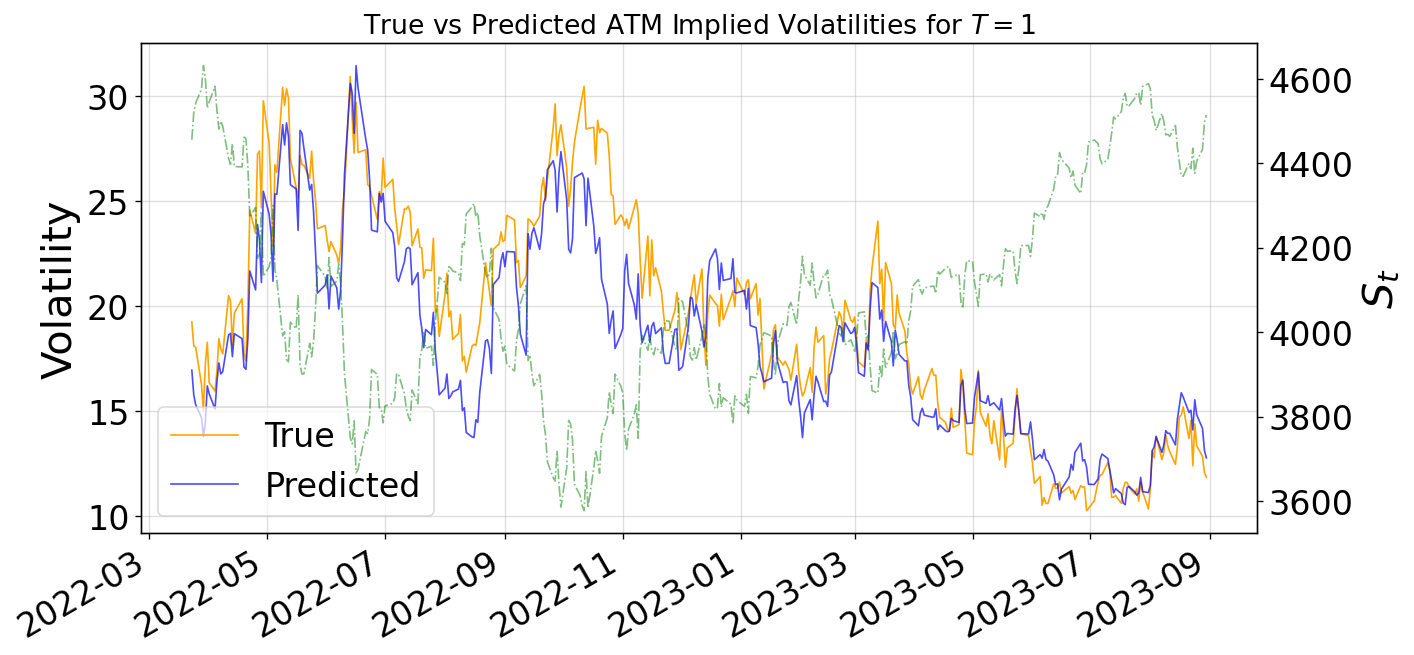

In [154]:
fig = plot_volatility_predictions(y_true=target_on_test, y_pred=pred_on_test, index_series=index_on_test)
fig.savefig('predictions.pdf', format='pdf')